# Hands-on - Ataques e Defesas de Inversão de Gradientes para Sistemas Federados

In [19]:
import utils
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torchvision import transforms
import numpy as np

In [20]:
dataset, transfor = utils.cria_dataset('cifar10')
modelo            = utils.cria_modelo('cifar10')

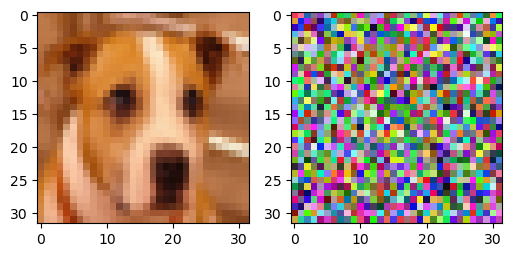

In [21]:
imagem, label = utils.get_imagem_e_label(21910, dataset, transfor, num_classes=10)
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())
utils.compara_imagens(imagem, imagem_fake)

# Ataque de Inversão de Gradientes com DLG

![DLG](imagens/dlg.jpg)

In [22]:
def run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados, 
               optimizer, criterion, ataque='dlg'):
    history     = []
    to_pilimage = transforms.ToPILImage()
    loop = tqdm(range(140), desc=f"🔧 Invertendo Gradientes...",  )
    for iters in loop: 
        def closure():
            optimizer.zero_grad()

            pred_ataque = modelo(imagem_fake)
            
            if ataque == 'dlg':
                onehot_ataque = F.softmax(label_fake, dim=-1)
                
            elif ataque == 'idlg':
                onehot_ataque = torch.argmin(torch.sum(gradientes_compartilhados[-2], 
                                                       dim=-1), dim=-1).detach().reshape((1,)).requires_grad_(False)
                
            loss_ataque       = criterion(pred_ataque, onehot_ataque) 
            gradientes_ataque = torch.autograd.grad(loss_ataque, modelo.parameters(), 
                                                    create_graph=True)
            grad_diff = 0
        
            for gx, gy in zip(gradientes_ataque, gradientes_compartilhados): 
                grad_diff += ((gx - gy) ** 2).sum()
                
            grad_diff.backward()

            return grad_diff

        optimizer.step(closure)
        current_loss = closure().item()
        loop.set_postfix(loss_inversao=current_loss)  # Atualiza a barra de progresso com a loss
        history.append(to_pilimage(imagem_fake[0].cpu()))
        
    return history

In [23]:
output_modelo    = modelo(imagem)
criterion        = utils.cross_entropy_for_onehot
logits           = criterion(output_modelo, label)
gradientes       = torch.autograd.grad(logits, modelo.parameters())

gradientes_compartilhados = list((_.detach().clone() for _ in gradientes))

🔧 Invertendo Gradientes...: 100%|██████████| 140/140 [00:05<00:00, 24.45it/s, loss_inversao=2.29e-6]


Label predito é 5.


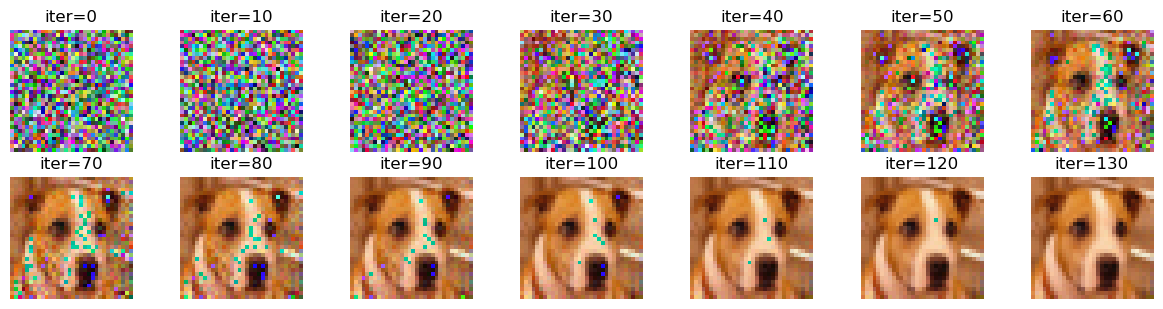

In [24]:
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())

optimizer_dlg = torch.optim.LBFGS([imagem_fake, label_fake], )
loss_dlg      = torch.nn.CrossEntropyLoss(reduction='none')
historico     = run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados,
                           optimizer_dlg, loss_dlg, ataque='dlg')
utils.plot_historico_ataque(historico, label_fake)

🔧 Invertendo Gradientes...: 100%|██████████| 140/140 [00:05<00:00, 25.01it/s, loss_inversao=1.21e-6]


Label predito é 2.


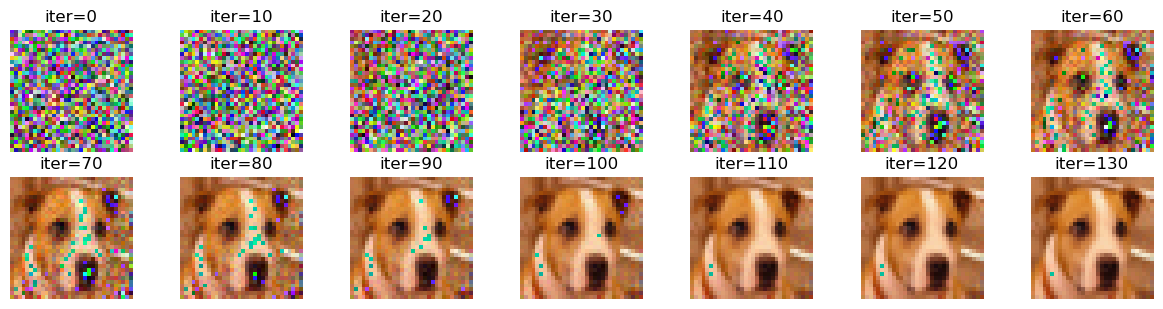

In [25]:
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())
optimizer_dlg = torch.optim.LBFGS([imagem_fake], )
loss_dlg      = torch.nn.CrossEntropyLoss(reduction='none')
historico     = run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados,
                           optimizer_dlg, loss_dlg, ataque='idlg')
utils.plot_historico_ataque(historico, label_fake)

# Defesas

## Poda de modelo

In [31]:
modelo = utils.cria_modelo('cifar10')
utils.poda_modelo(modelo, 0.4)
output_modelo    = modelo(imagem)
criterion        = utils.cross_entropy_for_onehot
logits           = criterion(output_modelo, label)
gradientes       = torch.autograd.grad(logits, modelo.parameters())

gradientes_compartilhados = list((_.detach().clone() for _ in gradientes))

Podando Layer body.0
Podando Layer body.2
Podando Layer body.4
Podando Layer body.6
Podando Layer fc.0


🔧 Invertendo Gradientes...: 100%|██████████| 140/140 [00:05<00:00, 23.55it/s, loss_inversao=8.24e-6]


Label predito é 5.


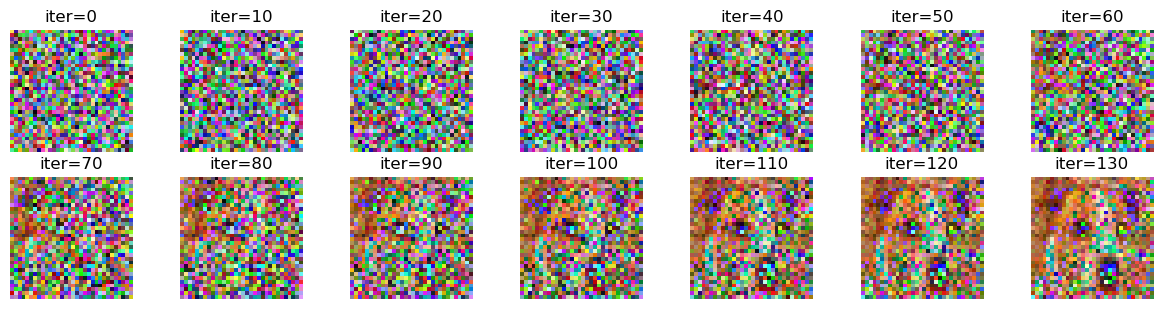

In [32]:
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())

optimizer_dlg = torch.optim.LBFGS([imagem_fake, label_fake], )
loss_dlg      = torch.nn.CrossEntropyLoss(reduction='none')
historico     = run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados,
                           optimizer_dlg, loss_dlg, ataque='dlg')
utils.plot_historico_ataque(historico, label_fake)

## Privacidade Diferencial

In [33]:
from flwr.common.differential_privacy import (
    compute_stdv,
    add_gaussian_noise_inplace
)

In [48]:
modelo = utils.cria_modelo('cifar10')
output_modelo    = modelo(imagem)
criterion        = utils.cross_entropy_for_onehot
logits           = criterion(output_modelo, label)
gradientes       = torch.autograd.grad(logits, modelo.parameters())

gradientes_compartilhados = list((_.detach().clone() for _ in gradientes))
#Converte gradientes para numpy
gradientes_compartilhados = [grad.detach().cpu().numpy() for grad in gradientes_compartilhados]

In [49]:
noise_multiplier = 0.03
clipping_norm    = 0.1
add_gaussian_noise_inplace(gradientes_compartilhados, compute_stdv(noise_multiplier, clipping_norm, 1))
#Converte gradientes para torch
gradientes_compartilhados = [torch.tensor(grad, requires_grad=True) for grad in gradientes_compartilhados]

🔧 Invertendo Gradientes...: 100%|██████████| 140/140 [00:05<00:00, 24.38it/s, loss_inversao=0.148]


Label predito é 5.


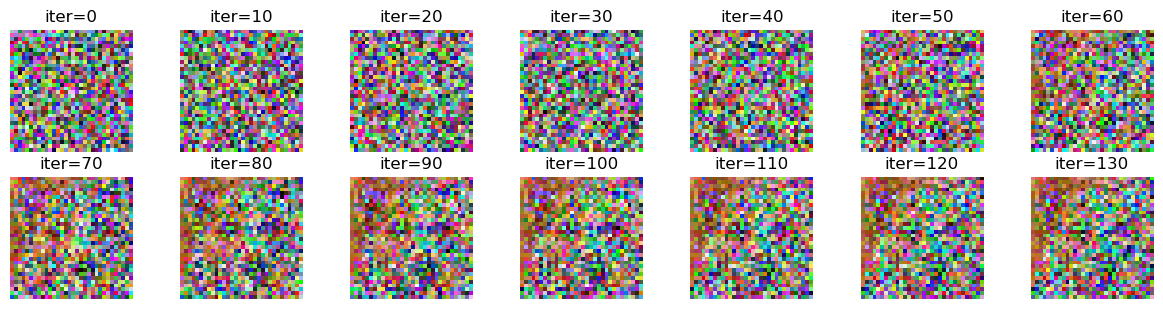

In [50]:
#realiza o ataque
imagem_fake, label_fake = utils.cria_ruido(imagem.size(), label.size())

optimizer_dlg = torch.optim.LBFGS([imagem_fake, label_fake], )
loss_dlg      = torch.nn.CrossEntropyLoss(reduction='none')
historico     = run_ataque(modelo, imagem_fake, label_fake, gradientes_compartilhados,
                           optimizer_dlg, loss_dlg, ataque='dlg')
utils.plot_historico_ataque(historico, label_fake)